In [169]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance

In [456]:
TRAIN_DATA_PATH = 'train_data/'
TEST_DATA_PATH = 'test_data/'
WINDOW_LENGTH = 3
DEFAULT_FEATURES = ['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']

In [444]:
def getDataset(path, features, flatten = True):
    dataset = []
    #features = ['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']
    for file_name in os.listdir(path):
        if '.csv' in file_name:
            df = pd.read_csv(path+ file_name)
            dataset.append(df)

    dataset = pd.concat(dataset)
    dataset = dataset.reset_index()
    dataset = dataset.reindex(np.random.permutation(dataset.index))

    X = dataset[features]
    Y = dataset[['indoors']]
    X = X.as_matrix()
    Y = Y.as_matrix()

    for index, x in np.ndenumerate(Y):
        if x not in [0,1,'0','1']:
            X = np.delete(X, (index[0]), axis=0)
            Y = np.delete(Y, (index[0]),axis=0)
    new_X = []
    new_Y = np.zeros((len(X) - WINDOW_LENGTH, 1))
    arr_i = 0
    side_size = int((WINDOW_LENGTH - 1) / 2)
    for i in range(side_size, len(X)):
        i_start = i - side_size
        i_end = i + side_size +1
        y_i = i
        dps = X[i_start:i_end, :]
        new_x = dps
        if flatten:
            new_x = dps.flatten()
        new_y = Y[y_i]
        if i_end >= len(X):
            break
        new_X.append(new_x)
        new_Y[arr_i] = new_y
        arr_i += 1
    X = np.asarray(new_X)
    Y = new_Y
    return X, Y

# Train I/O models

## Feedforward Neural Network

In [454]:
X_train, Y_train = getDataset(TRAIN_DATA_PATH, DEFAULT_FEATURES)
X_test, Y_test = getDataset(TEST_DATA_PATH, DEFAULT_FEATURES)

### Feature selection

In [447]:
features_list = []
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total'])
features_list.append(
    ['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total', 'baro_relative_altitude'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'baro_relative_altitude'])
features_list.append(['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total', 'baro_pressure'])

In [446]:
for features in features_list:
    X_train, Y_train = getDataset(TRAIN_DATA_PATH, features)
    X_test, Y_test = getDataset(TEST_DATA_PATH, features)
    FFW = Sequential()

    FFW.add(Dense(30, input_shape=(len(X_train[0]),)))
    FFW.add(Activation('relu'))

    FFW.add(Dense(18))
    FFW.add(BatchNormalization(axis=1))
    FFW.add(Dropout(0.7))
    FFW.add(Activation('relu'))

    FFW.add(Dense(1))
    FFW.add(BatchNormalization(axis=1))
    FFW.add(Activation('sigmoid'))

    FFW.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy'])

    save_model_path = 'best_model_FFW'
    modelcheckpoint = ModelCheckpoint(save_model_path, monitor = 'acc', verbose = 0, save_best_only = True)
    history_FFW = FFW.fit(X_train, Y_train, batch_size=128, epochs = 600, validation_split = 0.1, callbacks=[modelcheckpoint],verbose=0)
    FFW = load_model(save_model_path)
    accuracy = FFW.evaluate(X_test, Y_test)[1]
    print str(features) + str(accuracy)

6486/6486 [==============================] - 1s 208us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']0.8900709220225745
6486/6486 [==============================] - 1s 222us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total', 'baro_relative_altitude']0.8908418131176057
6486/6486 [==============================] - 1s 229us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy']0.8618563058160905
6486/6486 [==============================] - 2s 242us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed']0.8777366635279636
6486/6486 [==============================] - 2s 264us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength']0.8920752390681539
6486/6486 [==============================] - 2s 269us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']0.892229417187911
6486/6486 [===

In [455]:
FFW = Sequential()

FFW.add(Dense(30, input_shape=(len(X_train[0]),)))
FFW.add(Activation('relu'))

FFW.add(Dense(18))
FFW.add(BatchNormalization(axis=1))
FFW.add(Dropout(0.7))
FFW.add(Activation('relu'))

FFW.add(Dense(1))
FFW.add(BatchNormalization(axis=1))
FFW.add(Activation('sigmoid'))

FFW.summary()

FFW.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

save_model_path = 'best_model_FFW'
earlystopping = EarlyStopping(monitor = 'val_acc', patience=10)
modelcheckpoint = ModelCheckpoint(save_model_path, monitor = 'acc', verbose = 1, save_best_only = True)

history_FFW = FFW.fit(X_train, Y_train, batch_size=128, epochs = 600, validation_split = 0.1, callbacks=[modelcheckpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 30)                480       
_________________________________________________________________
activation_61 (Activation)   (None, 30)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 18)                558       
_________________________________________________________________
batch_normalization_41 (Batc (None, 18)                72        
_________________________________________________________________
dropout_21 (Dropout)         (None, 18)                0         
_________________________________________________________________
activation_62 (Activation)   (None, 18)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 19        
__________


Epoch 00033: acc did not improve
Epoch 34/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.5148 - acc: 0.8010 - val_loss: 0.4967 - val_acc: 0.7996

Epoch 00034: acc improved from 0.80013 to 0.80101, saving model to best_model_FFW
Epoch 35/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.5135 - acc: 0.7990 - val_loss: 0.4940 - val_acc: 0.8016

Epoch 00035: acc did not improve
Epoch 36/600
4573/4573 [==============================] - 0s 29us/step - loss: 0.5117 - acc: 0.8041 - val_loss: 0.4925 - val_acc: 0.8016

Epoch 00036: acc improved from 0.80101 to 0.80407, saving model to best_model_FFW
Epoch 37/600
4573/4573 [==============================] - 0s 35us/step - loss: 0.5121 - acc: 0.8021 - val_loss: 0.4902 - val_acc: 0.8016

Epoch 00037: acc did not improve
Epoch 38/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.5055 - acc: 0.8056 - val_loss: 0.4892 - val_acc: 0.8016

Epoch 00038: acc improved from 0.80407 to 0.80

4573/4573 [==============================] - 0s 27us/step - loss: 0.4499 - acc: 0.8395 - val_loss: 0.4228 - val_acc: 0.8664

Epoch 00077: acc did not improve
Epoch 78/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.4509 - acc: 0.8408 - val_loss: 0.4223 - val_acc: 0.8684

Epoch 00078: acc did not improve
Epoch 79/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.4475 - acc: 0.8406 - val_loss: 0.4211 - val_acc: 0.8762

Epoch 00079: acc did not improve
Epoch 80/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.4530 - acc: 0.8362 - val_loss: 0.4155 - val_acc: 0.8782

Epoch 00080: acc did not improve
Epoch 81/600
4573/4573 [==============================] - 0s 29us/step - loss: 0.4424 - acc: 0.8478 - val_loss: 0.4186 - val_acc: 0.8762

Epoch 00081: acc improved from 0.84277 to 0.84780, saving model to best_model_FFW
Epoch 82/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.4394 - acc: 0.8474 - val_los

4573/4573 [==============================] - 0s 33us/step - loss: 0.3978 - acc: 0.8679 - val_loss: 0.3548 - val_acc: 0.9175

Epoch 00121: acc did not improve
Epoch 122/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.3967 - acc: 0.8782 - val_loss: 0.3577 - val_acc: 0.9194

Epoch 00122: acc improved from 0.87514 to 0.87820, saving model to best_model_FFW
Epoch 123/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.3969 - acc: 0.8732 - val_loss: 0.3535 - val_acc: 0.9194

Epoch 00123: acc did not improve
Epoch 124/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.3956 - acc: 0.8769 - val_loss: 0.3555 - val_acc: 0.9194

Epoch 00124: acc did not improve
Epoch 125/600
4573/4573 [==============================] - 0s 34us/step - loss: 0.3961 - acc: 0.8732 - val_loss: 0.3518 - val_acc: 0.9214

Epoch 00125: acc did not improve
Epoch 126/600
4573/4573 [==============================] - 0s 30us/step - loss: 0.3878 - acc: 0.8819 - va

4573/4573 [==============================] - 0s 27us/step - loss: 0.3614 - acc: 0.8887 - val_loss: 0.3240 - val_acc: 0.9273

Epoch 00166: acc did not improve
Epoch 167/600
4573/4573 [==============================] - 0s 33us/step - loss: 0.3645 - acc: 0.8922 - val_loss: 0.3226 - val_acc: 0.9273

Epoch 00167: acc did not improve
Epoch 168/600
4573/4573 [==============================] - 0s 29us/step - loss: 0.3591 - acc: 0.8891 - val_loss: 0.3235 - val_acc: 0.9273

Epoch 00168: acc did not improve
Epoch 169/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.3612 - acc: 0.8896 - val_loss: 0.3188 - val_acc: 0.9273

Epoch 00169: acc did not improve
Epoch 170/600
4573/4573 [==============================] - 0s 30us/step - loss: 0.3582 - acc: 0.8922 - val_loss: 0.3176 - val_acc: 0.9273

Epoch 00170: acc did not improve
Epoch 171/600
4573/4573 [==============================] - 0s 30us/step - loss: 0.3648 - acc: 0.8909 - val_loss: 0.3146 - val_acc: 0.9273

Epoch 00171: ac

4573/4573 [==============================] - 0s 29us/step - loss: 0.3348 - acc: 0.9005 - val_loss: 0.2932 - val_acc: 0.9371

Epoch 00212: acc did not improve
Epoch 213/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.3382 - acc: 0.9003 - val_loss: 0.2910 - val_acc: 0.9371

Epoch 00213: acc did not improve
Epoch 214/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.3371 - acc: 0.9023 - val_loss: 0.2895 - val_acc: 0.9352

Epoch 00214: acc did not improve
Epoch 215/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.3373 - acc: 0.8992 - val_loss: 0.2945 - val_acc: 0.9371

Epoch 00215: acc did not improve
Epoch 216/600
4573/4573 [==============================] - 0s 29us/step - loss: 0.3342 - acc: 0.8994 - val_loss: 0.2909 - val_acc: 0.9371

Epoch 00216: acc did not improve
Epoch 217/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.3326 - acc: 0.9033 - val_loss: 0.2920 - val_acc: 0.9371

Epoch 00217: ac

4573/4573 [==============================] - 0s 26us/step - loss: 0.3183 - acc: 0.9058 - val_loss: 0.2701 - val_acc: 0.9391

Epoch 00259: acc did not improve
Epoch 260/600
4573/4573 [==============================] - 0s 25us/step - loss: 0.3157 - acc: 0.9090 - val_loss: 0.2738 - val_acc: 0.9391

Epoch 00260: acc did not improve
Epoch 261/600
4573/4573 [==============================] - 0s 29us/step - loss: 0.3187 - acc: 0.9082 - val_loss: 0.2711 - val_acc: 0.9391

Epoch 00261: acc did not improve
Epoch 262/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.3080 - acc: 0.9134 - val_loss: 0.2676 - val_acc: 0.9371

Epoch 00262: acc improved from 0.90903 to 0.91340, saving model to best_model_FFW
Epoch 263/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.3153 - acc: 0.9103 - val_loss: 0.2668 - val_acc: 0.9391

Epoch 00263: acc did not improve
Epoch 264/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.3178 - acc: 0.9062 - va

4573/4573 [==============================] - 0s 26us/step - loss: 0.3031 - acc: 0.9112 - val_loss: 0.2545 - val_acc: 0.9371

Epoch 00306: acc did not improve
Epoch 307/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2988 - acc: 0.9112 - val_loss: 0.2543 - val_acc: 0.9391

Epoch 00307: acc did not improve
Epoch 308/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2982 - acc: 0.9121 - val_loss: 0.2517 - val_acc: 0.9371

Epoch 00308: acc did not improve
Epoch 309/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.3043 - acc: 0.9068 - val_loss: 0.2528 - val_acc: 0.9371

Epoch 00309: acc did not improve
Epoch 310/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2949 - acc: 0.9132 - val_loss: 0.2550 - val_acc: 0.9371

Epoch 00310: acc did not improve
Epoch 311/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2984 - acc: 0.9130 - val_loss: 0.2561 - val_acc: 0.9371

Epoch 00311: ac

4573/4573 [==============================] - 0s 27us/step - loss: 0.2795 - acc: 0.9184 - val_loss: 0.2427 - val_acc: 0.9391

Epoch 00352: acc did not improve
Epoch 353/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2850 - acc: 0.9158 - val_loss: 0.2404 - val_acc: 0.9391

Epoch 00353: acc did not improve
Epoch 354/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2827 - acc: 0.9189 - val_loss: 0.2422 - val_acc: 0.9391

Epoch 00354: acc did not improve
Epoch 355/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2839 - acc: 0.9171 - val_loss: 0.2425 - val_acc: 0.9391

Epoch 00355: acc did not improve
Epoch 356/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2895 - acc: 0.9143 - val_loss: 0.2414 - val_acc: 0.9391

Epoch 00356: acc did not improve
Epoch 357/600
4573/4573 [==============================] - 0s 28us/step - loss: 0.2880 - acc: 0.9176 - val_loss: 0.2428 - val_acc: 0.9391

Epoch 00357: ac

4573/4573 [==============================] - 0s 29us/step - loss: 0.2807 - acc: 0.9193 - val_loss: 0.2321 - val_acc: 0.9411

Epoch 00398: acc did not improve
Epoch 399/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.2722 - acc: 0.9226 - val_loss: 0.2298 - val_acc: 0.9411

Epoch 00399: acc did not improve
Epoch 400/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.2746 - acc: 0.9224 - val_loss: 0.2266 - val_acc: 0.9411

Epoch 00400: acc did not improve
Epoch 401/600
4573/4573 [==============================] - 0s 32us/step - loss: 0.2771 - acc: 0.9202 - val_loss: 0.2276 - val_acc: 0.9411

Epoch 00401: acc did not improve
Epoch 402/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.2776 - acc: 0.9213 - val_loss: 0.2271 - val_acc: 0.9411

Epoch 00402: acc did not improve
Epoch 403/600
4573/4573 [==============================] - 0s 32us/step - loss: 0.2750 - acc: 0.9208 - val_loss: 0.2307 - val_acc: 0.9391

Epoch 00403: ac

4573/4573 [==============================] - 0s 31us/step - loss: 0.2609 - acc: 0.9270 - val_loss: 0.2197 - val_acc: 0.9391

Epoch 00444: acc did not improve
Epoch 445/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2689 - acc: 0.9252 - val_loss: 0.2202 - val_acc: 0.9391

Epoch 00445: acc did not improve
Epoch 446/600
4573/4573 [==============================] - 0s 30us/step - loss: 0.2686 - acc: 0.9226 - val_loss: 0.2210 - val_acc: 0.9391

Epoch 00446: acc did not improve
Epoch 447/600
4573/4573 [==============================] - 0s 34us/step - loss: 0.2588 - acc: 0.9252 - val_loss: 0.2230 - val_acc: 0.9411

Epoch 00447: acc did not improve
Epoch 448/600
4573/4573 [==============================] - 0s 33us/step - loss: 0.2651 - acc: 0.9246 - val_loss: 0.2250 - val_acc: 0.9411

Epoch 00448: acc did not improve
Epoch 449/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2660 - acc: 0.9243 - val_loss: 0.2233 - val_acc: 0.9391

Epoch 00449: ac

4573/4573 [==============================] - 0s 28us/step - loss: 0.2593 - acc: 0.9267 - val_loss: 0.2163 - val_acc: 0.9411

Epoch 00491: acc did not improve
Epoch 492/600
4573/4573 [==============================] - 0s 37us/step - loss: 0.2552 - acc: 0.9237 - val_loss: 0.2157 - val_acc: 0.9411

Epoch 00492: acc did not improve
Epoch 493/600
4573/4573 [==============================] - 0s 35us/step - loss: 0.2570 - acc: 0.9281 - val_loss: 0.2159 - val_acc: 0.9411

Epoch 00493: acc did not improve
Epoch 494/600
4573/4573 [==============================] - 0s 32us/step - loss: 0.2572 - acc: 0.9302 - val_loss: 0.2159 - val_acc: 0.9411

Epoch 00494: acc did not improve
Epoch 495/600
4573/4573 [==============================] - 0s 37us/step - loss: 0.2616 - acc: 0.9300 - val_loss: 0.2144 - val_acc: 0.9411

Epoch 00495: acc did not improve
Epoch 496/600
4573/4573 [==============================] - 0s 33us/step - loss: 0.2644 - acc: 0.9243 - val_loss: 0.2143 - val_acc: 0.9411

Epoch 00496: ac


Epoch 00538: acc did not improve
Epoch 539/600
4573/4573 [==============================] - 0s 30us/step - loss: 0.2533 - acc: 0.9270 - val_loss: 0.2130 - val_acc: 0.9411

Epoch 00539: acc did not improve
Epoch 540/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.2572 - acc: 0.9257 - val_loss: 0.2114 - val_acc: 0.9411

Epoch 00540: acc did not improve
Epoch 541/600
4573/4573 [==============================] - 0s 32us/step - loss: 0.2498 - acc: 0.9287 - val_loss: 0.2104 - val_acc: 0.9411

Epoch 00541: acc did not improve
Epoch 542/600
4573/4573 [==============================] - 0s 34us/step - loss: 0.2493 - acc: 0.9305 - val_loss: 0.2097 - val_acc: 0.9411

Epoch 00542: acc did not improve
Epoch 543/600
4573/4573 [==============================] - 0s 33us/step - loss: 0.2516 - acc: 0.9309 - val_loss: 0.2109 - val_acc: 0.9430

Epoch 00543: acc did not improve
Epoch 544/600
4573/4573 [==============================] - 0s 34us/step - loss: 0.2535 - acc: 0.9298 - val

4573/4573 [==============================] - 0s 33us/step - loss: 0.2543 - acc: 0.9281 - val_loss: 0.2064 - val_acc: 0.9411

Epoch 00586: acc did not improve
Epoch 587/600
4573/4573 [==============================] - 0s 34us/step - loss: 0.2461 - acc: 0.9307 - val_loss: 0.2058 - val_acc: 0.9411

Epoch 00587: acc did not improve
Epoch 588/600
4573/4573 [==============================] - 0s 31us/step - loss: 0.2456 - acc: 0.9270 - val_loss: 0.2053 - val_acc: 0.9411

Epoch 00588: acc did not improve
Epoch 589/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2462 - acc: 0.9278 - val_loss: 0.2060 - val_acc: 0.9411

Epoch 00589: acc did not improve
Epoch 590/600
4573/4573 [==============================] - 0s 27us/step - loss: 0.2500 - acc: 0.9285 - val_loss: 0.2050 - val_acc: 0.9411

Epoch 00590: acc did not improve
Epoch 591/600
4573/4573 [==============================] - 0s 26us/step - loss: 0.2426 - acc: 0.9307 - val_loss: 0.2050 - val_acc: 0.9411

Epoch 00591: ac

In [160]:
FFW = load_model(save_model_path)
accuracy = FFW.evaluate(X_test, Y_test)[1]
print accuracy

6486/6486 [==============================] - 0s 66us/step
0.8959296947638635


## LSTM

In [460]:
X_train, Y_train = getDataset(TRAIN_DATA_PATH, DEFAULT_FEATURES, flatten=False)
X_test, Y_test = getDataset(TEST_DATA_PATH, DEFAULT_FEATURES, flatten=False)

In [449]:
for features in features_list:
    X_train, Y_train = getDataset(TRAIN_DATA_PATH, features,flatten=False)
    X_test, Y_test = getDataset(TEST_DATA_PATH, features,flatten=False)
    ltsm = Sequential()
    ltsm.add(LSTM(128, input_shape=(3, len(X_train[0][0])), return_sequences=True,
                   dropout=0.2, recurrent_dropout=0.2))
    ltsm.add(LSTM(2))
    ltsm.add(Dense(1, activation='sigmoid'))

    ltsm.compile(loss='binary_crossentropy',
                  optimizer=Adam(0.006),
                  metrics=['accuracy'])

    save_model_path = 'best_model_LSTM'
    modelcheckpoint = ModelCheckpoint(save_model_path, monitor = 'acc', verbose = 0, save_best_only = True)
    history_lstm = ltsm.fit(X_train, Y_train, batch_size=128, epochs = 600, validation_split = 0.1, callbacks=[modelcheckpoint],verbose=0)
    ltsm = load_model(save_model_path)
    accuracy = ltsm.evaluate(X_test, Y_test)[1]
    print str(features) + str(accuracy)

6486/6486 [==============================] - 2s 342us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']0.8928461301631851
6486/6486 [==============================] - 2s 378us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total', 'baro_relative_altitude']0.8942337342886288
6486/6486 [==============================] - 2s 384us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy']0.8595436324758585
6486/6486 [==============================] - 3s 403us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed']0.8715695343633658
6486/6486 [==============================] - 3s 432us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength']0.8618563058712289
6486/6486 [==============================] - 3s 483us/step
['gps_vertical_accuracy', 'gps_horizontal_accuracy', 'gps_speed', 'rssi_strength', 'magnet_total']0.8945420907486966
6486/6486 [==

In [461]:
ltsm = Sequential()
ltsm.add(LSTM(128, input_shape=(3, len(X_train[0][0])), return_sequences=True,
                   dropout=0.2, recurrent_dropout=0.2))
    # model.add(LSTM(hparams.nb_rnn_units_l2, return_sequences=True, dropout=hparams.drop_rate,
    #                recurrent_dropout=hparams.drop_rate))
ltsm.add(LSTM(2))
ltsm.add(Dense(1, activation='sigmoid'))
ltsm.summary()

ltsm.compile(loss='binary_crossentropy',
              optimizer=Adam(0.006),
              metrics=['accuracy'])

save_model_path = 'best_model_LSTM'
earlystopping = EarlyStopping(monitor = 'val_acc', patience=10)
modelcheckpoint = ModelCheckpoint(save_model_path, monitor = 'acc', verbose = 1, save_best_only = True)

history_lstm = ltsm.fit(X_train, Y_train, batch_size=128, epochs = 600, validation_split = 0.1, callbacks=[modelcheckpoint])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 3, 128)            68608     
_________________________________________________________________
lstm_22 (LSTM)               (None, 2)                 1048      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 3         
Total params: 69,659
Trainable params: 69,659
Non-trainable params: 0
_________________________________________________________________
Train on 4573 samples, validate on 509 samples
Epoch 1/600
4573/4573 [==============================] - 8s 2ms/step - loss: 0.6399 - acc: 0.6350 - val_loss: 0.5958 - val_acc: 0.6916

Epoch 00001: acc improved from -inf to 0.63503, saving model to best_model_LSTM
Epoch 2/600
4573/4573 [==============================] - 0s 84us/step - loss: 0.5684 - acc: 0.7407 - val_loss: 0.5403 - val_acc: 0.7839

Ep

4573/4573 [==============================] - 0s 86us/step - loss: 0.2950 - acc: 0.9033 - val_loss: 0.3247 - val_acc: 0.8998

Epoch 00041: acc did not improve
Epoch 42/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2811 - acc: 0.9119 - val_loss: 0.3218 - val_acc: 0.8998

Epoch 00042: acc did not improve
Epoch 43/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2695 - acc: 0.9138 - val_loss: 0.2901 - val_acc: 0.8998

Epoch 00043: acc did not improve
Epoch 44/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2751 - acc: 0.9134 - val_loss: 0.3225 - val_acc: 0.8998

Epoch 00044: acc did not improve
Epoch 45/600
4573/4573 [==============================] - 0s 89us/step - loss: 0.2709 - acc: 0.9145 - val_loss: 0.2923 - val_acc: 0.8998

Epoch 00045: acc did not improve
Epoch 46/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2742 - acc: 0.9152 - val_loss: 0.3270 - val_acc: 0.8998

Epoch 00046: acc did


Epoch 00088: acc did not improve
Epoch 89/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2340 - acc: 0.9320 - val_loss: 0.2336 - val_acc: 0.9371

Epoch 00089: acc did not improve
Epoch 90/600
4573/4573 [==============================] - 0s 93us/step - loss: 0.2434 - acc: 0.9283 - val_loss: 0.2136 - val_acc: 0.9489

Epoch 00090: acc did not improve
Epoch 91/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2409 - acc: 0.9316 - val_loss: 0.2123 - val_acc: 0.9489

Epoch 00091: acc did not improve
Epoch 92/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.3099 - acc: 0.8926 - val_loss: 0.2780 - val_acc: 0.8959

Epoch 00092: acc did not improve
Epoch 93/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2680 - acc: 0.9197 - val_loss: 0.2382 - val_acc: 0.9411

Epoch 00093: acc did not improve
Epoch 94/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2582 - acc: 0.9230 - val_loss:

4573/4573 [==============================] - 0s 86us/step - loss: 0.2364 - acc: 0.9305 - val_loss: 0.2041 - val_acc: 0.9509

Epoch 00136: acc did not improve
Epoch 137/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2371 - acc: 0.9318 - val_loss: 0.2015 - val_acc: 0.9509

Epoch 00137: acc did not improve
Epoch 138/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2449 - acc: 0.9276 - val_loss: 0.2052 - val_acc: 0.9489

Epoch 00138: acc did not improve
Epoch 139/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2407 - acc: 0.9298 - val_loss: 0.2376 - val_acc: 0.9391

Epoch 00139: acc did not improve
Epoch 140/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2437 - acc: 0.9289 - val_loss: 0.2007 - val_acc: 0.9509

Epoch 00140: acc did not improve
Epoch 141/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2497 - acc: 0.9274 - val_loss: 0.2384 - val_acc: 0.9411

Epoch 00141: ac


Epoch 00183: acc did not improve
Epoch 184/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2593 - acc: 0.9219 - val_loss: 0.2124 - val_acc: 0.9489

Epoch 00184: acc did not improve
Epoch 185/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2468 - acc: 0.9281 - val_loss: 0.2048 - val_acc: 0.9509

Epoch 00185: acc did not improve
Epoch 186/600
4573/4573 [==============================] - 0s 91us/step - loss: 0.2394 - acc: 0.9309 - val_loss: 0.2378 - val_acc: 0.9391

Epoch 00186: acc did not improve
Epoch 187/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2460 - acc: 0.9281 - val_loss: 0.2034 - val_acc: 0.9509

Epoch 00187: acc did not improve
Epoch 188/600
4573/4573 [==============================] - 0s 93us/step - loss: 0.2417 - acc: 0.9289 - val_loss: 0.2186 - val_acc: 0.9450

Epoch 00188: acc did not improve
Epoch 189/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2511 - acc: 0.9283 - val

4573/4573 [==============================] - 0s 86us/step - loss: 0.2541 - acc: 0.9252 - val_loss: 0.2166 - val_acc: 0.9489

Epoch 00231: acc did not improve
Epoch 232/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2448 - acc: 0.9283 - val_loss: 0.2078 - val_acc: 0.9489

Epoch 00232: acc did not improve
Epoch 233/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2296 - acc: 0.9359 - val_loss: 0.2010 - val_acc: 0.9509

Epoch 00233: acc did not improve
Epoch 234/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2439 - acc: 0.9291 - val_loss: 0.2513 - val_acc: 0.9293

Epoch 00234: acc did not improve
Epoch 235/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2534 - acc: 0.9270 - val_loss: 0.2096 - val_acc: 0.9509

Epoch 00235: acc did not improve
Epoch 236/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2523 - acc: 0.9263 - val_loss: 0.2074 - val_acc: 0.9489

Epoch 00236: ac


Epoch 00278: acc did not improve
Epoch 279/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2498 - acc: 0.9257 - val_loss: 0.2056 - val_acc: 0.9509

Epoch 00279: acc did not improve
Epoch 280/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2514 - acc: 0.9257 - val_loss: 0.2038 - val_acc: 0.9528

Epoch 00280: acc did not improve
Epoch 281/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2444 - acc: 0.9285 - val_loss: 0.2134 - val_acc: 0.9470

Epoch 00281: acc did not improve
Epoch 282/600
4573/4573 [==============================] - 0s 85us/step - loss: 0.2474 - acc: 0.9283 - val_loss: 0.2252 - val_acc: 0.9450

Epoch 00282: acc did not improve
Epoch 283/600
4573/4573 [==============================] - 0s 83us/step - loss: 0.2437 - acc: 0.9307 - val_loss: 0.2024 - val_acc: 0.9528

Epoch 00283: acc did not improve
Epoch 284/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2439 - acc: 0.9291 - val

4573/4573 [==============================] - 0s 88us/step - loss: 0.2436 - acc: 0.9285 - val_loss: 0.2046 - val_acc: 0.9509

Epoch 00326: acc did not improve
Epoch 327/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2472 - acc: 0.9294 - val_loss: 0.2117 - val_acc: 0.9509

Epoch 00327: acc did not improve
Epoch 328/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2456 - acc: 0.9298 - val_loss: 0.2237 - val_acc: 0.9430

Epoch 00328: acc did not improve
Epoch 329/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2444 - acc: 0.9287 - val_loss: 0.2129 - val_acc: 0.9470

Epoch 00329: acc did not improve
Epoch 330/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2454 - acc: 0.9278 - val_loss: 0.2048 - val_acc: 0.9509

Epoch 00330: acc did not improve
Epoch 331/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2464 - acc: 0.9283 - val_loss: 0.2047 - val_acc: 0.9509

Epoch 00331: ac


Epoch 00373: acc did not improve
Epoch 374/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2517 - acc: 0.9267 - val_loss: 0.1997 - val_acc: 0.9528

Epoch 00374: acc did not improve
Epoch 375/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2486 - acc: 0.9274 - val_loss: 0.2112 - val_acc: 0.9509

Epoch 00375: acc did not improve
Epoch 376/600
4573/4573 [==============================] - 0s 90us/step - loss: 0.2460 - acc: 0.9294 - val_loss: 0.1992 - val_acc: 0.9528

Epoch 00376: acc did not improve
Epoch 377/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2415 - acc: 0.9313 - val_loss: 0.1979 - val_acc: 0.9528

Epoch 00377: acc did not improve
Epoch 378/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2452 - acc: 0.9283 - val_loss: 0.2301 - val_acc: 0.9430

Epoch 00378: acc did not improve
Epoch 379/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2450 - acc: 0.9281 - val

4573/4573 [==============================] - 0s 87us/step - loss: 0.2409 - acc: 0.9307 - val_loss: 0.2295 - val_acc: 0.9411

Epoch 00421: acc did not improve
Epoch 422/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2562 - acc: 0.9224 - val_loss: 0.2296 - val_acc: 0.9430

Epoch 00422: acc did not improve
Epoch 423/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2507 - acc: 0.9263 - val_loss: 0.2184 - val_acc: 0.9489

Epoch 00423: acc did not improve
Epoch 424/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2403 - acc: 0.9309 - val_loss: 0.2229 - val_acc: 0.9450

Epoch 00424: acc did not improve
Epoch 425/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2357 - acc: 0.9322 - val_loss: 0.2173 - val_acc: 0.9450

Epoch 00425: acc did not improve
Epoch 426/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2371 - acc: 0.9335 - val_loss: 0.2022 - val_acc: 0.9509

Epoch 00426: ac

4573/4573 [==============================] - 0s 88us/step - loss: 0.2420 - acc: 0.9309 - val_loss: 0.2241 - val_acc: 0.9470

Epoch 00468: acc did not improve
Epoch 469/600
4573/4573 [==============================] - 0s 89us/step - loss: 0.2419 - acc: 0.9305 - val_loss: 0.2322 - val_acc: 0.9411

Epoch 00469: acc did not improve
Epoch 470/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2514 - acc: 0.9272 - val_loss: 0.2385 - val_acc: 0.9371

Epoch 00470: acc did not improve
Epoch 471/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2493 - acc: 0.9270 - val_loss: 0.2118 - val_acc: 0.9509

Epoch 00471: acc did not improve
Epoch 472/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2374 - acc: 0.9322 - val_loss: 0.2022 - val_acc: 0.9528

Epoch 00472: acc did not improve
Epoch 473/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2479 - acc: 0.9283 - val_loss: 0.2349 - val_acc: 0.9391

Epoch 00473: ac

4573/4573 [==============================] - 0s 87us/step - loss: 0.2376 - acc: 0.9326 - val_loss: 0.2098 - val_acc: 0.9509

Epoch 00515: acc did not improve
Epoch 516/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2366 - acc: 0.9335 - val_loss: 0.1989 - val_acc: 0.9528

Epoch 00516: acc did not improve
Epoch 517/600
4573/4573 [==============================] - 0s 88us/step - loss: 0.2356 - acc: 0.9340 - val_loss: 0.1993 - val_acc: 0.9528

Epoch 00517: acc did not improve
Epoch 518/600
4573/4573 [==============================] - 0s 86us/step - loss: 0.2284 - acc: 0.9357 - val_loss: 0.2168 - val_acc: 0.9450

Epoch 00518: acc did not improve
Epoch 519/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2387 - acc: 0.9320 - val_loss: 0.2240 - val_acc: 0.9450

Epoch 00519: acc did not improve
Epoch 520/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2352 - acc: 0.9333 - val_loss: 0.2082 - val_acc: 0.9489

Epoch 00520: ac


Epoch 00562: acc did not improve
Epoch 563/600
4573/4573 [==============================] - 0s 91us/step - loss: 0.2725 - acc: 0.9154 - val_loss: 0.3213 - val_acc: 0.8998

Epoch 00563: acc did not improve
Epoch 564/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2820 - acc: 0.9114 - val_loss: 0.3639 - val_acc: 0.8998

Epoch 00564: acc did not improve
Epoch 565/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2856 - acc: 0.9127 - val_loss: 0.3260 - val_acc: 0.8998

Epoch 00565: acc did not improve
Epoch 566/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2731 - acc: 0.9160 - val_loss: 0.3243 - val_acc: 0.8998

Epoch 00566: acc did not improve
Epoch 567/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2736 - acc: 0.9138 - val_loss: 0.3225 - val_acc: 0.8998

Epoch 00567: acc did not improve
Epoch 568/600
4573/4573 [==============================] - 0s 87us/step - loss: 0.2746 - acc: 0.9141 - val

In [163]:
ltsm = load_model(save_model_path)
accuracy = ltsm.evaluate(X_test, Y_test)[1]
print accuracy

6486/6486 [==============================] - 1s 146us/step
0.8977798335794089


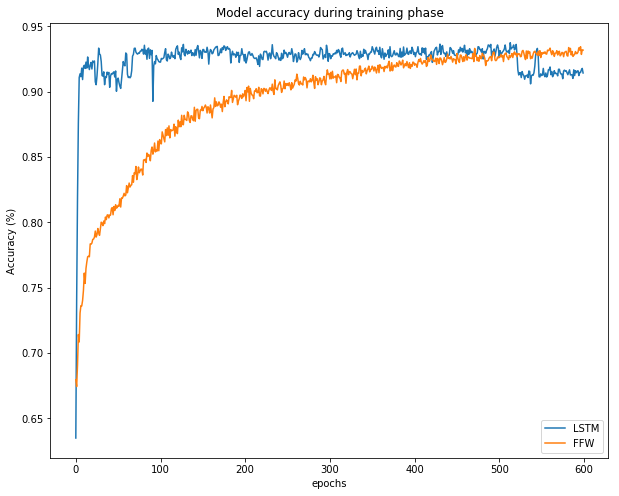

In [551]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(history_lstm.history["acc"], label = 'LSTM')
plt.plot(history_FFW.history["acc"], label = "FFW")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("Accuracy (%)")
plt.title("Model accuracy during training phase")
plt.show()

## SVM

In [164]:
X_train, Y_train = getDataset(TRAIN_DATA_PATH, flatten=True)
X_test, Y_test = getDataset(TEST_DATA_PATH, flatten=True)

In [165]:
SVM = SVC(gamma=1e-05, kernel='rbf', C=4)
SVM.fit(X_train, Y_train)

train_score = SVM.score(X_train, Y_train)
test_score = SVM.score(X_test, Y_test) 
print train_score
print test_score

0.9470680834317198
0.8558433549182856


## Logistic Regression

In [166]:
X_train, Y_train = getDataset(TRAIN_DATA_PATH, flatten=True)
X_test, Y_test = getDataset(TEST_DATA_PATH, flatten=True)

In [167]:
LR = LogisticRegression(C=1e5)
LR.fit(X_train, Y_train)

train_score = LR.score(X_train, Y_train)
test_score = LR.score(X_test, Y_test)
print train_score
print test_score

0.9000393545848091
0.7180080172679618


## Random Forest

In [168]:
RF = RandomForestClassifier(n_estimators=5)
RF.fit(X_train, Y_train)

train_score = RF.score(X_train, Y_train)
test_score = RF.score(X_test, Y_test)
print train_score
print test_score

0.9970484061393152
0.8304039469626888


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


# Floor Prediction

Most of this code has been taken from author official GitHub (mentionnned in his paper)

In [509]:
def find_io_intervals(dfa, min_similarity):
    # ---------------
    # define IO vector mask
    target_vector_in_out = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
    target_vector_in_out = np.add(target_vector_in_out, 1).tolist()
    target_vector_out_in = target_vector_in_out[::-1]
    window_size = len(target_vector_in_out)

    preds = dfa['indoors_prediction'].tolist()
    # ---------------
    # find matches
    matches = []
    for i in range(0, len(preds) - window_size):
        vec = preds[i: i + window_size]
        vec = np.add(vec, 1)
        
        dist_a = distance.jaccard(target_vector_in_out, vec)
        dist_b = distance.jaccard(vec, target_vector_out_in)
        
        if dist_a >= min_similarity:
            matches.append(i)

        elif dist_b >= min_similarity:
            matches.append(i)

    sorted(matches)
    
    # ---------------
    # Group matches
    merged = [(matches[0], matches[0] + 2)]
    for start in matches[1:]:
        end = start+2

        merged_start, merged_end = merged[-1]

        if (start <= merged_end):
            merged[-1] = (merged_start, max(merged_end, end))

        else:
            merged.append((start, end))
        
    # --------------
    # FIND PEAKS
    #print('Merged interval groups:')
    #print(merged)
    stack = []
    for x, y in merged:
        avg = np.mean([x,y])
        stack.append(avg)

    #print('\nFinal Transition locations (ith datapoint):')
    #print(stack)
    peaks_detected_by_classifier = stack
    return peaks_detected_by_classifier

In [510]:
def get_last_transition_dp(dfa, peaks_detected_by_classifier):
    last_transition_index = int(peaks_detected_by_classifier[-1])
    dp = dfa.iloc[[last_transition_index]]
    return dp, last_transition_index

In [511]:
def predict_dfs(frames,model):
    accuracies = []
    predicted = []
    for df in frames:
        X, Y = create_test_data(df, X_features =
                            ['gps_vertical_accuracy', 
                             'gps_horizontal_accuracy', 
                             'gps_speed', 
                             'rssi_strength', 
                             'magnet_total'], 
                            Y_label='indoors', model=model)
        df, accuracy = predict(model, df, X, Y)
        predicted.append(df)
        accuracies.append(float("{0:.2f}".format(accuracy)))
    avg_acc = np.mean(accuracies)
    print('avg acc NN: ', float("{0:.3f}".format(avg_acc)))
    return predicted, accuracies

In [512]:
def predict(model, df, X, Y, window_length=3):
    
    df_with_window = df[0:-window_length]
    if model == 'LSTM':
        preds = ltsm.predict(X)
        accuracy = ltsm.evaluate(X, Y, verbose=0)[1]
        #results = np.argmax(preds, axis=1).reshape(len(preds), 1)
        #results = np.ones(len(preds))
        results = (preds > 0.5).astype(int)
    if model == 'FFW':
        preds = FFW.predict(X)
        accuracy = FFW.evaluate(X, Y, verbose=0)[1]
        #results = np.argmax(preds, axis=1).reshape(len(preds), 1)
        results = (preds > 0.5).astype(int)
    if model == 'SVM':
        preds = SVM.predict(X)
        results = preds.reshape(len(X), 1)
        df_with_window['indoors_prediction'] = results
        accuracy = df_with_window[df_with_window.indoors == df_with_window.indoors_prediction].count()['indoors'] / float(len(df_with_window))
    if model == 'RF':
        preds = RF.predict(X)
        results = preds.reshape(len(X), 1)
        df_with_window['indoors_prediction'] = results
        accuracy = df_with_window[df_with_window.indoors == df_with_window.indoors_prediction].count()['indoors'] / float(len(df_with_window))
    if model == 'LR':
        preds = LR.predict(X)
        results = preds.reshape(len(X), 1)
        df_with_window['indoors_prediction'] = results
        accuracy = df_with_window[df_with_window.indoors == df_with_window.indoors_prediction].count()['indoors'] / float(len(df_with_window))
        
    
    # save to new df
    df_with_window['indoors_prediction'] = results
        

    return df_with_window, accuracy

In [513]:
def create_test_data(df, X_features, Y_label, model):
    X = df[X_features]
    Y = df[[Y_label]]

    X = X.as_matrix()
    Y = Y.as_matrix()

    new_X = []
    new_Y = np.zeros((len(X) - WINDOW_LENGTH, 1))
    arr_i = 0
    side_size = int((WINDOW_LENGTH - 1) /2)
    for i in range(side_size, len(X)):
        i_start = i - side_size
        i_end = i + side_size + 1
        y_i = i
        dps = X[i_start:i_end, :]
        new_x = dps
        if model !='LSTM':
            new_x = dps.flatten()
        new_y = Y[y_i]
        if i_end >= len(X):
            break
        new_X.append(new_x)
        new_Y[arr_i] = new_y
        arr_i += 1
    
    new_X = np.asarray(new_X)
    return new_X, new_Y

In [514]:
def load_data(model, data_path):
    frames = []
    frames_names = []
    for file_name in os.listdir(data_path):
        if 'csv' in file_name:
        #if 'csv' in file_name and '_' in file_name:
            in_path = '%s/%s' % (data_path, file_name)
            df = pd.read_csv(in_path)
            df = df.fillna(0)
            frames.append(df)
            frames_names.append(file_name)
    # add weather data
    for df in frames:
        df['weather_pressure'] = [100] * len(df)
    
    frames, accuracies = predict_dfs(frames,model)
    return frames, frames_names
        

In [540]:
def find_optimal_transition_point(dfa, last_transition_index):
    num_points_around_transition = 10
    lookback_window = 20
    #print('last transition idx: ', last_transition_index)
    
    before = dfa[last_transition_index - num_points_around_transition : last_transition_index]
    after = dfa[last_transition_index : last_transition_index + num_points_around_transition]
    before_mean_pressure = np.mean(before.baro_pressure)
    after_mean_pressure = np.mean(after.baro_pressure)
    direction_change = "pos" if before_mean_pressure < after_mean_pressure else "neg"
    if last_transition_index < lookback_window:
        return dfa.iloc[[0]], -1
    if direction_change is "pos":
        optimal_point = np.argmin(dfa.baro_pressure[last_transition_index - lookback_window : last_transition_index]) 
    else:
        optimal_point = np.argmax(dfa.baro_pressure[last_transition_index - lookback_window : last_transition_index]) 

    #print('optimal transition idx: ', optimal_point)
    dp = dfa.iloc[[optimal_point]]
    
    return dp, 1

In [516]:
def predict_current_floor(dp, last_dp, floor_height_meters):
    # pressure readings at time of last transition
    transition_device_pressure = dp.baro_pressure.values[0]
    weather_pressure_at_transition = dp.weather_pressure.values[0]

    # pressure readings at current point
    current_device_pressure = last_dp.baro_pressure.values[0]
    current_weather_pressure = last_dp.weather_pressure.values[0]

    # calculate weather pressure delta
    weather_pressure_delta = current_weather_pressure - weather_pressure_at_transition

    # calculate device pressure delta
    weather_adjusted_start_device_pressure = transition_device_pressure + weather_pressure_delta

    # this is the difference between pressures formula
    # the answer is in meters
    total_meter_change = 44330 * (1 - (current_device_pressure/weather_adjusted_start_device_pressure)**(1/5.255))

    # floor detection rule
    floor_delta = int(total_meter_change / floor_height_meters)
    if floor_delta >= 0:
        current_floor = 1 + floor_delta
    else:
        current_floor = floor_delta
    
    return current_floor, total_meter_change, floor_delta

In [517]:
def get_io_status(dfa, last_transition_index):
    after_last_transition_points = dfa[last_transition_index : ]
    indoor_preds = after_last_transition_points.indoors_prediction
    pcnt_inside = indoor_preds[indoor_preds == 1].sum() / float(len(indoor_preds))
    inside_status = 'indoors' if pcnt_inside > 0.5 else 'outdoors'
    return inside_status

In [518]:
def ground_truth_floor(test_name):
    real_floor = test_name.split('_')
    #print(real_floor)
    real_floor_start = int(real_floor[2])
    real_floor_end = int(real_floor[-1].split('.')[0])
    floor_delta = real_floor_end - real_floor_start
    #floor_delta = floor_delta + 1 if real_floor_start < real_floor_end else floor_delta - 1
    return floor_delta, real_floor_start, real_floor_end

In [538]:
def predict_floor(path, model, floor_height_meters=4.02, heights=None):
    results = {'exact_floor':0, 'near_miss':0, 'large_miss':0}
    number_wrong_csv = 0
    frames, frames_names = load_data(model, path)
    for i, dfa in enumerate(frames):
        dfa = frames[i]
        test_name = frames_names[i]
        if heights is not None:
            test_start = test_name.split('_')[0]
            floor_height_meters = heights[test_start]
        
        # detect peaks
        peaks_detected_by_classifier = find_io_intervals(dfa, min_similarity=0.6)
        # find last point a transition happened
        last_transition_dp, last_transition_index = get_last_transition_dp(dfa, peaks_detected_by_classifier)
        #print (len(dfa) - last_transition_index)
        # last dp of user loc
        last_dp = dfa.iloc[[-1]]
        # find point where the optimal transition happened
        # this is the loéwest point around a transition window
        optimal_trans_dp, return_code = find_optimal_transition_point(dfa, last_transition_index)
        if return_code == -1:
            number_wrong_csv += 1
            continue
        
        # make floor pred
        current_floor, total_meter_change, predicted_floor_delta = predict_current_floor(optimal_trans_dp, last_dp, floor_height_meters=floor_height_meters)
        
        # determine if indoors or not
        io_status = get_io_status(dfa, last_transition_index)

        # print real floor info
        floor_delta, real_floor_start, real_floor_end = ground_truth_floor(test_name)
        #flr_heights.append(total_meter_change / floor_delta)
        if floor_delta == predicted_floor_delta:
            results['exact_floor'] += 1
        elif floor_delta - 1 <= predicted_floor_delta <= floor_delta + 1:
            results['near_miss'] += 1
        else:
            results['large_miss'] += 1
        #print {'pred_delta': predicted_floor_delta, 'predicted': current_floor, 'real_delta': floor_delta, 'name': test_name, 'test_start': real_floor_start, 'test_end': real_floor_end}
    print "Number of experiments: "+str(i+1-number_wrong_csv)
    print "Exact Floor: "+str(results['exact_floor'] / float(i+1-number_wrong_csv))
    print "Floor +- 1: "+str(results['near_miss'] / float(i+1-number_wrong_csv))
    print "Floor > 1: "+str(results['large_miss'] / float(i+1-number_wrong_csv))

#### JACCARD DISTANCE = 0.6 , LOOKBACK WINDOW = 20

In [520]:
predict_floor(TEST_DATA_PATH, 'LSTM', heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.854)
Number of experiments: 63
Exact Floor: 1.0
Floor +- 1: 0.0
Floor > 1: 0.0


In [521]:
predict_floor(TEST_DATA_PATH, 'LSTM')

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.854)
Number of experiments: 63
Exact Floor: 0.634920634921
Floor +- 1: 0.365079365079
Floor > 1: 0.0


In [541]:
predict_floor(TEST_DATA_PATH, 'FFW', heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.897)
Number of experiments: 61
Exact Floor: 1.0
Floor +- 1: 0.0
Floor > 1: 0.0


In [542]:
predict_floor(TEST_DATA_PATH, 'FFW')

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.897)
Number of experiments: 61
Exact Floor: 0.639344262295
Floor +- 1: 0.360655737705
Floor > 1: 0.0


In [543]:
predict_floor(TEST_DATA_PATH, 'SVM', heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.873)
Number of experiments: 63
Exact Floor: 1.0
Floor +- 1: 0.0
Floor > 1: 0.0


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [544]:
predict_floor(TEST_DATA_PATH, 'SVM')

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.873)
Number of experiments: 63
Exact Floor: 0.619047619048
Floor +- 1: 0.380952380952
Floor > 1: 0.0


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [545]:
predict_floor(TEST_DATA_PATH, 'RF', heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.825)
Number of experiments: 56
Exact Floor: 1.0
Floor +- 1: 0.0
Floor > 1: 0.0


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [546]:
predict_floor(TEST_DATA_PATH, 'RF')

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.825)
Number of experiments: 56
Exact Floor: 0.625
Floor +- 1: 0.375
Floor > 1: 0.0


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [547]:
predict_floor(TEST_DATA_PATH, 'LR', heights={'gsb': 3.8, 'mudd': 3.4, 'noco': 4.2, 'ssw': 3.9, 'rock': 3.8})

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.671)
Number of experiments: 63
Exact Floor: 1.0
Floor +- 1: 0.0
Floor > 1: 0.0


/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [548]:
predict_floor(TEST_DATA_PATH, 'LR')

/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/maxencehull/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('avg acc NN: ', 0.671)
Number of experiments: 63
Exact Floor: 0.634920634921
Floor +- 1: 0.365079365079
Floor > 1: 0.0
